In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imread
from scipy.ndimage import gaussian_filter
from scipy.sparse import csr_matrix, isspmatrix

In [2]:
adata_exp0 = anndata.read_h5ad('C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/spatial/counts_CPc_exp0_BA28.h5ad')

In [3]:
adata_Yao = anndata.read_h5ad(
    'C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/sc/Yao_150kcells_subsample_with_annotations_sparse_subset.h5ad')

In [4]:
adata_Yao.obs["celltype"] = adata_Yao.obs["label"]

In [5]:
def get_negative_marker_dict(adata_sp: AnnData, adata_sc: AnnData, key: str='celltype'):
    """add dictionary of negative marker genes for different celltypes
    
    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    key : str
        Celltype key in adata_sp.obs and adata_sc.obs

    Returns
    -------
    neg_marker_dict : dict[string: list]
        dictionary with celltypes as keys and corresponding negative marker genes as values
    """

    # Set threshold parameters
    min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
    max_ratio_cells=0.005 # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair

    #check that genes in spatial data is subset of genes in single cell data
    adata_sp = adata_sp[:,adata_sp.var_names.isin(adata_sc.var_names)]

    # Subset adata_sc to genes of spatial data
    adata_sc = adata_sc[:,adata_sp.var_names]           
    
    adata_sc.layers["raw"] = adata_sc.X
    # TMP fix for sparse matrices, ideally we don't convert, and instead have calculations for sparse/non-sparse
    
    if isspmatrix(adata_sc.layers["raw"]):                                   #existiert dieser layer immer ->X?
        adata_sc.layers["raw"] = adata_sc.layers["raw"].toarray()

    # Get cell types that we find in both modalities
    shared_celltypes = adata_sc.obs.loc[adata_sc.obs[key].isin(adata_sp.obs[key]),key].unique()
    
    # Filter cell types by minimum number of cells
    celltype_count_sc = adata_sc.obs[key].value_counts().loc[shared_celltypes]
    celltype_count_sp = adata_sc.obs[key].value_counts().loc[shared_celltypes]   
    ct_filter = (celltype_count_sc >= min_number_cells) & (celltype_count_sp >= min_number_cells)
    celltypes = celltype_count_sc.loc[ct_filter].index.tolist()             
    
    
    # Filter cells to eligible cell types
    adata_sc = adata_sc[adata_sc.obs[key].isin(celltypes)]
    genes = adata_sc.var_names
    
    # Get ratio of positive cells per cell type
    pos_exp_sc = pd.DataFrame(adata_sc.layers["raw"] > 0,columns=adata_sp.var_names)     
    pos_exp_sc['celltype'] = list(adata_sc.obs[key])
    ratio_celltype_sc = pos_exp_sc.groupby('celltype').mean()
    
    # Get gene-cell type pairs with negative marker expression
    neg_marker_mask = np.array(ratio_celltype_sc < max_ratio_cells)
    

    neg_marker_mask = pd.DataFrame(neg_marker_mask, columns = genes, index = ratio_celltype_sc.index)   
    neg_marker_dict = {celltype: [] for celltype in celltypes}

    for celltype, row in neg_marker_mask.iterrows():
        for gene in genes:
            if row[gene]:
                neg_marker_dict[celltype].append(gene)

    return neg_marker_dict


In [ ]:
# # Set threshold parameters
# min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
# max_ratio_cells=0.005 # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair

# #check that genes in spatial data is subset of genes in single cell data
# adata_exp0 = adata_exp0[:,adata_exp0.var_names.isin(adata_Yao.var_names)]

# # Subset adata_sc to genes of spatial data
# adata_Yao = adata_Yao[:,adata_exp0.var_names]    

# # Get cell types that we find in both modalities
# shared_celltypes = adata_Yao.obs.loc[adata_Yao.obs["celltype"].isin(adata_exp0.obs["celltype"]),"celltype"].unique()

# celltype_count_sc = adata_Yao.obs["celltype"].value_counts().loc[shared_celltypes]
# celltype_count_sp = adata_exp0.obs["celltype"].value_counts().loc[shared_celltypes]  

# ct_filter = (celltype_count_sc >= min_number_cells) & (celltype_count_sp >= min_number_cells)
# celltypes = celltype_count_sc.loc[ct_filter].index.tolist()             #zelltypen in beiden größer als min_number_cells unique
    
# len(celltypes)

# # Filter cells to eligible cell types
# adata_Yao = adata_Yao[adata_Yao.obs["celltype"].isin(celltypes)]
# genes = adata_Yao.var_names

# # Get ratio of positive cells per cell type

# pos_exp_sc = pd.DataFrame(adata_Yao.X.toarray() > 0,columns=adata_Yao.var_names)      #wieso hier nur TRUE False, unten echter mean
# pos_exp_sc['celltype'] = list(adata_Yao.obs["celltype"])
# ratio_celltype_sc = pos_exp_sc.groupby('celltype').mean()

# ratio_celltype_sc


In [6]:
#test negative_marker_mask
dict_exp0 = get_negative_marker_dict(adata_sp = adata_exp0, adata_sc = adata_Yao, key ='celltype')
len(dict_exp0.keys())

21

In [32]:
def get_neg_mark_read_in_corr_ct(adata_sp: AnnData, adata_sc: AnnData):

    """add column in_correct_celltype and 

       in_correct_celltype is TRUE, if gene is in_correct_celltype, else FALSE. 

       Parameters
       ----------
       adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
       adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    
       Returns
       ----------
       pandas DataFrame

    """

    df = adata_sp.uns["spots"]  
   
    neg_marker_dict = get_negative_marker_dict(adata_sp, adata_sc)

    celltypes = list(neg_marker_dict.keys())   

    df["in_correct_celltype"] = "Unknown"
    df.loc[df["celltype"].isin(celltypes), "in_correct_celltype"] = "True"


    # df = df.loc[df["celltype"].isin(celltypes)]         #alternative: diese zellen einfach filtern? dann spart man sich die zweite spalte

    for ct in celltypes:
      df.loc[(df["Gene"].isin(neg_marker_dict[ct])) & (df["celltype"] == ct), 'in_correct_celltype'] = "False"      
    
    return df

In [33]:
#test get_boolean_column
df_exp0 = get_neg_mark_read_in_corr_ct(adata_sp=adata_exp0, adata_sc=adata_Yao)
print(df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max())

12.245943333879998 13779.88508614 23.3559417021 19435.64276574


In [35]:
df_exp0["in_correct_celltype"]

0          Unknown
1             True
2             True
3             True
4             True
            ...   
9451287       True
9451288       True
9451289       True
9451290      False
9451291    Unknown
Name: in_correct_celltype, Length: 9451292, dtype: object

In [11]:
x_min, x_max, y_min, y_max = df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max()

In [49]:
def plot_spots(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, show_ticks: bool = False):
    """plot gene spots
     
     spot is red if entry in 'in_correct_celltype' is False, blue if True, grey if unknown

     Parameters
     ----------
     spots : pd.DataFrame
          pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
     x_min : int, x_max : int, y_min : int, y_max : int 
          crop coordinates
     image : NDArray
          read from image of dapi stained cell-nuclei
     show_ticks : bool 
          default False, show no ticks or labels
    """

    df = spots
    s_factor = 0.6          #richtig wählen(x_min,...)
    
    fig, ax = plt.subplots()

    ax.axis([x_min, x_max, y_max, y_min])        
    ax.imshow(image,cmap = "binary_r") 

    #filter spots
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]
    
    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)

    ax.scatter(df.loc[df['in_correct_celltype']=="Unknown","x"],df.loc[df['in_correct_celltype']=="Unknown","y"], s = 0.3*s_factor, color = "grey")
    ax.scatter(df.loc[df['in_correct_celltype']=="True","x"],df.loc[df['in_correct_celltype']=="True","y"], s = 0.5*s_factor, color = "blue")
    ax.scatter(df.loc[df['in_correct_celltype']=="False","x"],df.loc[df['in_correct_celltype']=="False","y"], s = 1*s_factor, color = "red")


    # size prop zu r oder array? 
    
    

In [13]:
image = imread(r"C:\Users\mdichgan\Documents\Helmholtz\send_to_Jakob\tif_images\background.tiff")

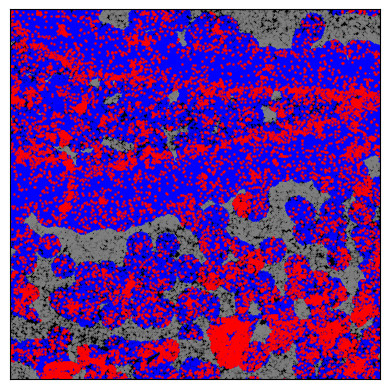

In [50]:
plot_spots(df_exp0, 10000,12500,10000,12500,image)

In [40]:
df_exp0.loc[df_exp0["in_correct_celltype"] == "False"]

,Gene,x,y,celltype,cell,in_correct_celltype
6,Sox10,182.384863,5228.706666,Endo,NaN,False
13,Fign,1412.041060,4934.683446,SMC-Peri,NaN,False
32,Lyz2,381.855503,5230.492555,Astro,NaN,False
33,Sox10,1109.938468,5252.310520,Astro,NaN,False
59,Sst,2069.315525,4952.259512,SMC-Peri,NaN,False
...,...,...,...,...,...,...
9451206,Acsbg1,13536.645586,8541.881444,Endo,13845.0,False
9451220,Nts,12298.466354,8798.838172,Oligo,NaN,False
9451226,Fgd5,13024.971667,8893.913823,Oligo,NaN,False
9451266,Parm1,12673.837644,8598.769186,CR,13200.0,False


In [67]:
def get_neg_spot_dens_array(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """get density array of negative spots

    Parameters
    ----------
    spots : pd.DataFrame
        pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of negative marker reads per bin
    range : range of binning 
    """
     
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")        #or better: either provide a crop (x_min, x_max, y_min, y_max) or image? 
        
    if image is None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
    

    #filter spots
    df = spots
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    true_spots = df.loc[df['in_correct_celltype'] == "True"]
    x_t = true_spots['x']
    y_t = true_spots['y']
    H_t, x_edges, y_edges = np.histogram2d(x_t, y_t, bins = bins, range = range)
    # Histogram does not follow Cartesian convention,
    # therefore transpose H for visualization purposes.
    H_t = H_t.T

    false_spots = df.loc[df['in_correct_celltype'] == "False"]
    x_f = false_spots['x']
    y_f = false_spots['y']
    H_f, x_edges, y_edges = np.histogram2d(x_f, y_f, bins = bins, range = range)
    H_f = H_f.T


    H = H_f/(H_t+H_f)    #ignore "Unknown" spots in density calculation, since it could be both True or False
    H[np.isnan(H)] = 0      #no negative marker wrongly assigned where no spots

    np.seterr(invalid='ignore')

    return H,range
    

In [68]:
get_neg_spot_dens_array(df_exp0,10000,12500,10000,12500,image=None,bins = 20)

(array([[0.01707989, 0.01404494, 0.01844427, 0.01693122, 0.04402516,
         0.03846154, 0.04347826, 0.07321429, 0.07554672, 0.03208556,
         0.06735751, 0.13736264, 0.09375   , 0.        , 0.        ,
         0.17391304, 0.08791209, 0.09090909, 0.33333333, 0.14754098],
        [0.07366771, 0.01738672, 0.01422764, 0.00870511, 0.01049869,
         0.01328273, 0.07075472, 0.07905687, 0.02889246, 0.04065041,
         0.05132743, 0.11166253, 0.03601108, 0.07407407, 0.        ,
         0.03846154, 0.08152174, 0.10377358, 0.0877193 , 0.03960396],
        [0.10921502, 0.03984576, 0.04002761, 0.02460539, 0.0061082 ,
         0.00942902, 0.01497006, 0.01432958, 0.0071475 , 0.01956522,
         0.01386623, 0.01712655, 0.01795143, 0.02545069, 0.01952278,
         0.01461988, 0.01591187, 0.01083591, 0.02061006, 0.01501706],
        [0.08695652, 0.06521739, 0.05527638, 0.13520408, 0.04973545,
         0.03747658, 0.04126214, 0.02779207, 0.01604278, 0.01607502,
         0.01500938, 0.01190476

In [69]:
def wrong_spot_density(spots: pd.DataFrame, x_min: int, x_max: int, y_min: int, y_max: int,
                       image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    
    """plot wrong spot density

    Parameters
    ----------
    spots : pd.DataFrame
        pd.DataFrame with columns: gene, x, y, celltype, in_correct_celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    H, range = get_neg_spot_dens_array(spots,x_min,x_max,y_min,y_max,image,bins)
    H = gaussian_filter(H,sigma=smooth)
    x_min, x_max, y_min, y_max = range[0][0], range[0][1], range[1][0], range[1][1]


    fig = plt.figure()
    ax = fig.add_subplot(title='false spots density')
    plot = plt.imshow(H, interpolation='nearest', origin='upper',
            extent=[x_min, x_max, y_max, y_min], vmin=0,vmax=1)
    fig.colorbar(plot)

    if show_ticks:
        ax.tick_params(which='both', direction='in')
    else:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)



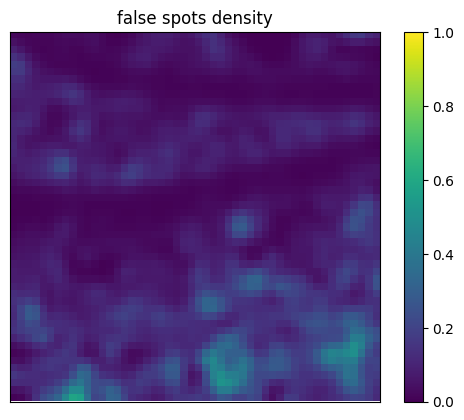

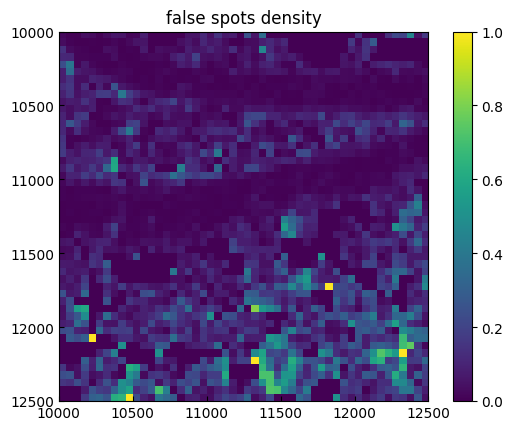

In [70]:
wrong_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 50, smooth=1)
wrong_spot_density(df_exp0,10000,12500,10000,12500,image=None,bins = 50, show_ticks=True)

In [ ]:
x = imread(r"C:\Users\mdichgan\Documents\Helmholtz\send_to_Jakob\tif_images\background.tiff")


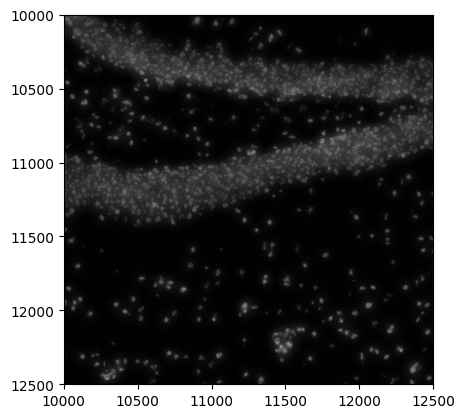

In [158]:
fig, ax = plt.subplots()
ax.axis([10000,12500, 12500,10000])        
plot = ax.imshow(x,cmap = "binary_r", origin = 'upper') 